### CB example (Carolina Reyes)

1. DataSet
2. Inferir Fx Costo
3. Simunlar el modelo (varios tipos de learners)
4. Evaluar los learners
5. Obtener el modelo

In [1]:
import pandas as pd

### Extracción de Datos

In [2]:
df=pd.read_csv('sim1.csv')
df.head()

,Unnamed: 0,user_id,af0,cycle,educ,gender,age,activity_id,af1,af2,dificulty,topic,prob,run_number
0,0,1,51,1,4,1,51,201,51,84,1,2,0.33,1
1,1,1,51,2,4,1,51,86,50,53,2,3,0.33,1
2,2,1,51,3,4,1,51,136,57,60,3,3,0.33,1
3,3,1,51,4,4,1,51,159,55,64,1,1,0.33,1
4,4,1,51,5,4,1,51,173,52,59,3,2,0.33,1


In [3]:
df.drop(columns=df.columns[0], axis=1, inplace=True)
df['cost'] =  df['af1'] - df['af2'] 

In [4]:
df.drop(columns=['af2','user_id','af1','cycle','topic','run_number','prob'], axis=1, inplace=True)
df.head()

,af0,educ,gender,age,activity_id,dificulty,cost
0,51,4,1,51,201,1,-33
1,51,4,1,51,86,2,-3
2,51,4,1,51,136,3,-3
3,51,4,1,51,159,1,-9
4,51,4,1,51,173,3,-7


In [5]:
df['educ'].unique()

array([4, 2, 1, 5, 3])

In [6]:
df.to_csv('sim2detec')

In [7]:
train_df = df[df.index < 70000]
test_df = df[df.index >= 70000]
test_df.reset_index

<bound method DataFrame.reset_index of        af0  educ  gender  age  activity_id  dificulty  cost
70000   48     5       0   45           42          2    -7
70001   48     5       0   45           20          3    -2
70002   48     5       0   45          144          4    -3
70003   48     5       0   45          167          5    -4
70004   48     5       0   45           37          5    -1
...    ...   ...     ...  ...          ...        ...   ...
99995   50     4       0   38           57          5    -1
99996   50     4       0   38           76          4    -9
99997   50     4       0   38          240          5     4
99998   50     4       0   38          156          3   -12
99999   50     4       0   38          128          4    -9

[30000 rows x 7 columns]>

### Modelo para determinar la Función de Costo

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def train_xgboost_regressor(train_data, train_labels, test_data, test_labels):
    # Define the XGBoost regressor
    reg = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        max_depth=4,
        learning_rate=0.18793869,
        gamma=0.03805912,
        min_child_weight=4.9259686,
        subsample=0.89705926,
        colsample_bytree=0.9011847,
        seed=42
    )

    # Train the XGBoost model
    reg.fit(train_data, train_labels)

    # Evaluate the model on the test data
    predictions = reg.predict(test_data)
    mse = mean_squared_error(test_labels, predictions)

    # Return the trained model and the mean squared error
    return reg, mse
     

In [10]:

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X_train=train_df.drop(columns=['cost','activity_id'], axis=1, inplace=False)
y_train=train_df['cost']

X_test=test_df.drop(columns=['cost', 'activity_id'], axis=1, inplace=False)
y_test=test_df['cost']


# Train an XGBoost regressor on the data
model, mse = train_xgboost_regressor(X_train, y_train, X_test, y_test)

# Print the MSE
print('MSE:', mse)
     

MSE: 52.77263387945041


In [11]:
X_train.head()

,af0,educ,gender,age,dificulty
0,51,4,1,51,1
1,51,4,1,51,2
2,51,4,1,51,3
3,51,4,1,51,1
4,51,4,1,51,3


In [12]:
def get_cost(af0, educ, gender, age, dificulty, model):
    
    usuario=pd.DataFrame({'af0':af0, 'educ':educ, 'gender':gender, 'age':age, 'dificulty':dificulty}, index=[1])
    costo=model.predict(usuario)
    return costo[0]

### Generar Learners

In [13]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt

In [14]:
df2=pd.read_csv('sim1.csv')
df2.drop(columns=['Unnamed: 0','af2','run_number'], axis=1, inplace=True)
df3=df2.groupby(['user_id'], as_index=False).mean()
df3.describe()
dificultad=[1,2,3,4,5]

In [15]:
df_user = df3

In [16]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [17]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user:{} age:{} gender:{} af0:{} educ:{}\n".format(
        context["user"], context["age"], context["gender"], context["af0"], context["educ"] 
    )   
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action dificultad:{} \n".format(action)
    # Strip the last newline
    #print(example_string[:-1])
    return example_string[:-1]

In [18]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [19]:
def run_simulation(vw, df_user, num_iterations, actions, get_action, get_cost, label):
  
    # das= Dificultad a Sugerir
    das = []
    act = []
    
  
    for j in range(len(df_user)):
        cost_sum = 0.0
        cost_us = []
        act_us = []
        for i in range(1, num_iterations + 1):
            
            datos_vw=[]   
            user = df_user.iloc[j]['user_id']
            gender=df_user.iloc[j]['gender']
            age=df_user.iloc[j]['age']
            af0=df_user.iloc[j]['af0']
            educ=df_user.iloc[j]['educ']

            contextos = {"user": user, "age": age, "gender":gender, "af0":af0, "educ":educ}
            dificulty, prob = get_action(vw, contextos, actions)
            cost = get_cost(int(af0), int(educ), int(gender), int(float(age)), int(dificulty),  model)
            cost_sum += float(cost)

            if label:
                vw_format=vw.parse(
                    to_vw_example_format(contextos, dificultad, (dificulty, cost, prob)),
                    vowpalwabbit.LabelType.CONTEXTUAL_BANDIT)
                vw.learn(vw_format)

            else:
                datos_vw.append(to_vw_example_format(contextos, dificultad))

            cost_us.append(-1 * cost_sum / i)
            act_us.append(dificulty)
        das.append(cost_us)
        act.append(act_us)
        
        
    return das, act   

        

In [20]:
def plot_das(num_iterations, das):
    plt.plot(range(1, num_iterations + 1), das)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("das", fontsize=14)
 

In [21]:
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --epsilon 0.2")
num_iterations=20
das, act = run_simulation(vw, df_user, num_iterations, dificultad, get_action, get_cost, label=True)

pd.DataFrame(das)
pd.DataFrame(act)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4,5,5,5,5,5,5,5,5,5,5,5,3,3,5,5,4,4,3,5
1,5,5,5,5,2,5,5,5,5,5,5,5,5,5,5,4,5,5,5,5
2,5,5,5,5,1,5,5,5,5,5,5,5,5,5,5,4,5,5,2,5
3,5,5,5,5,4,5,4,5,5,5,5,2,1,5,5,5,2,5,5,5
4,5,3,5,5,4,5,5,5,5,5,5,5,5,5,2,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,2,3
4996,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,5
4997,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,2,1,1,1,1
4998,1,1,1,1,2,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1


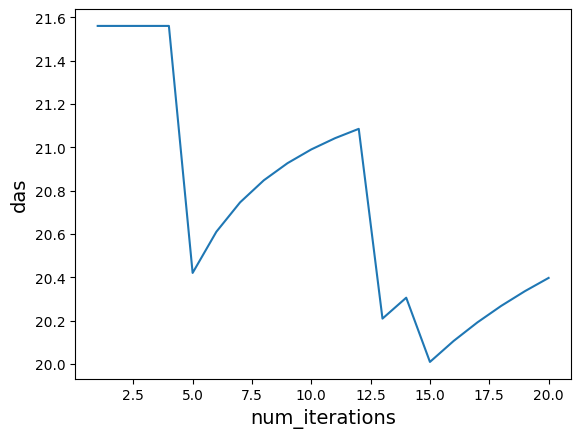

In [22]:
plot_das(num_iterations, das[4000])

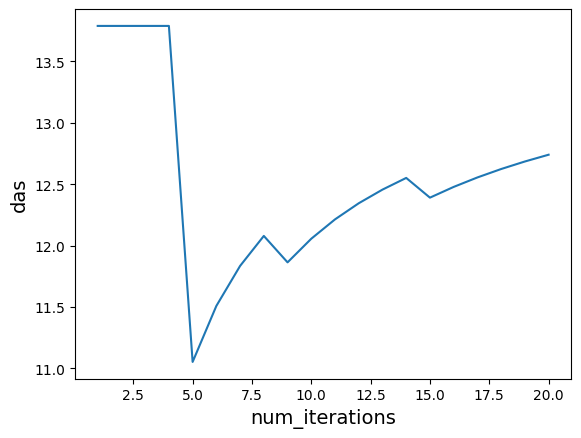

In [23]:
plot_das(num_iterations, das[23])